In [35]:
# Main libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm


# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler

# Scikit-learn: Models
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    RandomForestClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    accuracy_score, 
    auc, 
    classification_report, 
    confusion_matrix, 
    roc_curve
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Imbalanced-learn: Sampling techniques
from imblearn.under_sampling import RandomUnderSampler


In [36]:
df = pd.read_csv('dataset/obesity_train.csv')

# ETL for classification

In [37]:
# Dizionario di mapping
mapping = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}

# Applicare la trasformazione
df['weight_status'] = df['Obesity'].map(mapping).fillna(7).astype(int)


In [38]:
df['weight_status'].value_counts()

weight_status
4    324
6    323
5    293
2    266
0    261
3    260
1    174
Name: count, dtype: int64

## Normalizzazzione

In [39]:
# Dizionario di mapping
mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

mapping_features =['CALC', 'CAEC']
# Applicare il mapping
df[mapping_features] = df[mapping_features].apply(lambda x: x.map(mapping))


In [40]:
# Dizionario di mapping
mapping = {
    'no': False,
    'yes': True
}

mapping_features =['SMOKE', 'family_history','FAVC', 'SCC']
# Applicare il mapping
df[mapping_features] = df[mapping_features].apply(lambda x: x.map(mapping))


In [41]:
scaler = StandardScaler()

standard_features = ['Height', 'Age','FCVC','NCP', 'FAF','TUE', 'CH2O']
df[standard_features] = scaler.fit_transform(df[standard_features])


In [42]:
drop_features = [
    'Obesity', 'Weight'
]

df = df.drop(columns=drop_features, errors='ignore')

In [43]:
# Create dummies - for better model outcomes
df = pd.get_dummies(df, drop_first=True)

In [44]:
df.head()

,Age,Height,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,weight_status,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.680954,1.030798,True,True,-0.810046,0.404830,2,False,-0.006830,False,-1.202433,0.558800,0,5,True,False,False,True,False
1,-0.521688,-0.796845,False,True,-0.810046,-2.227844,1,False,-1.647924,False,-0.000467,0.558800,0,1,False,False,False,True,False
2,-0.043892,-2.194455,True,False,-0.810046,-2.227844,1,False,-0.006830,False,-1.202433,-1.118717,0,3,False,False,False,True,False
3,-0.521688,1.030798,True,True,1.078010,0.404830,1,False,-0.006830,False,-0.000467,-1.118717,0,1,True,False,False,True,False
4,-0.521688,-0.581829,True,True,-0.810046,0.404830,1,False,-0.006830,False,-0.000467,-1.118717,1,1,True,False,False,True,False


# Correlation Analysis

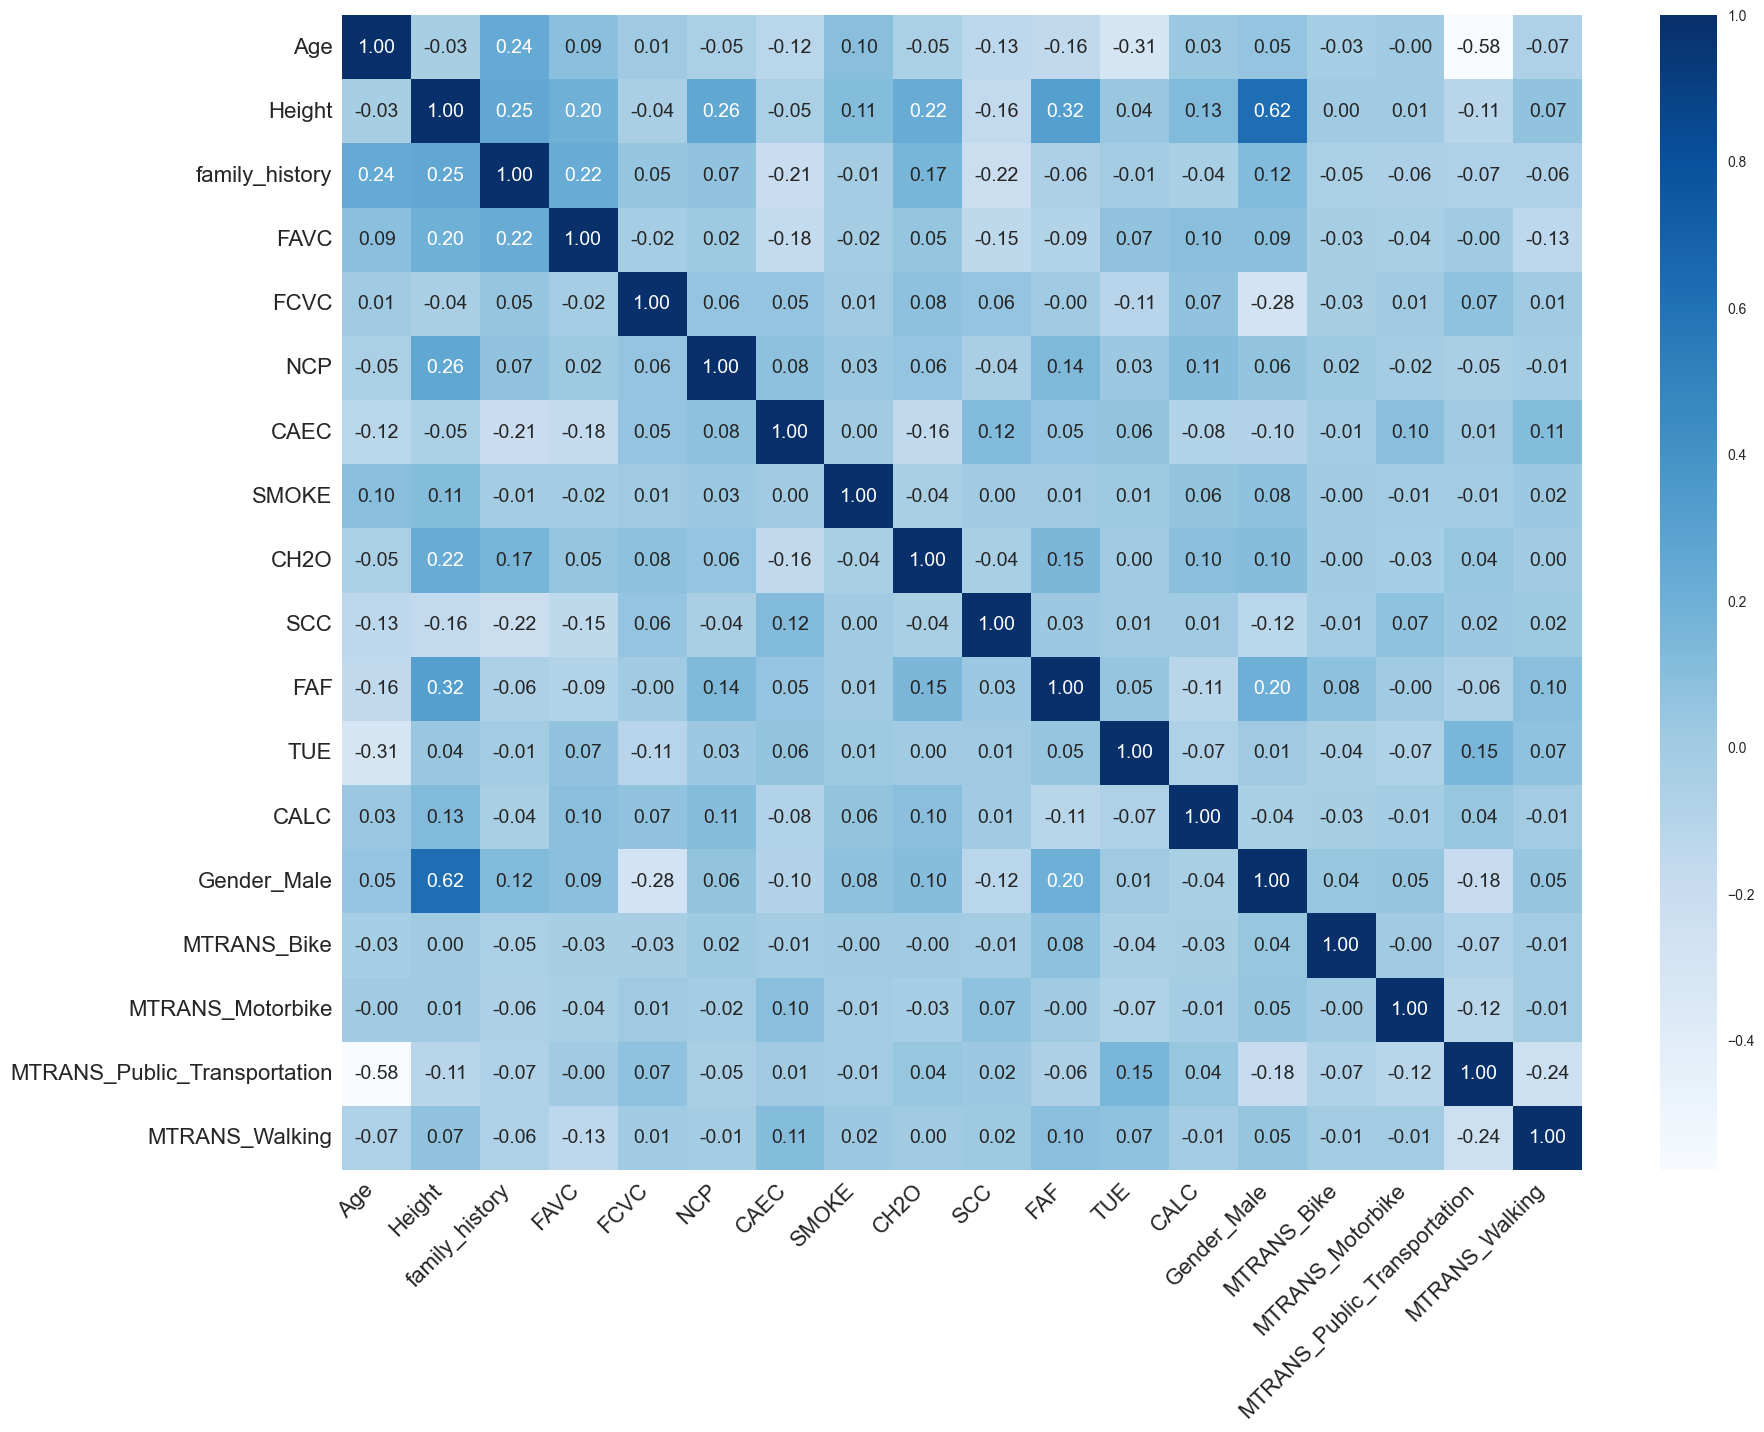

In [45]:
# Creazione della heatmap
plt.figure(figsize=(20, 15))
ax = sns.heatmap(df.drop(['weight_status'], axis=1).corr(), cmap="Blues", annot=True, fmt=".2f", annot_kws={"size": 14})  

# Aumenta la dimensione dei label degli assi
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45, ha='right')  # Rotazione per leggibilità
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.show()

# Classificazione

In [46]:
y = df['weight_status']
x = df.drop(columns=['weight_status'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1520, 18)
(381, 18)
(1520,)
(381,)


## Bilanciamento

In [47]:
sample = 140

# Crea una strategia di undersampling personalizzata
undersampler = RandomUnderSampler(
    sampling_strategy={0: sample, 1: sample, 2: sample, 3: sample, 4: sample, 
                    6: sample,
                    5: sample}, 
    random_state=42
)

# Applica l'undersampling al set di addestramento
x_train, y_train = undersampler.fit_resample(x_train, y_train)

# Controlla la distribuzione delle classi dopo l'undersampling
print(y_train.value_counts())


weight_status
0    140
1    140
2    140
3    140
4    140
5    140
6    140
Name: count, dtype: int64


## Training

In [48]:
# Definizione dei classificatori con i parametri modificati per ridurre l'overfitting
classifiers = [
    LogisticRegression(penalty='l2', random_state=rs),  # Regularizzazione L2
    DecisionTreeClassifier(random_state=rs, max_depth=5, min_samples_split=10),  # Potatura
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=rs),  # Limita il numero di alberi e profondità
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=rs),  # Early stopping
    GaussianNB(),  # Naive Bayes (con probabilità di overfitting ridotto)
    LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),  # LDA con regolarizzazione
    SVC(C=1, kernel='linear', probability=True),  # SVC con C ridotto per regolarizzazione
    XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=rs)  # XGBoost con regolarizzazione
]

# Lista dei risultati che avverranno
clf_name = []  # nomi dei classificatori
model_results = pd.DataFrame(y_test.copy())

kfold = StratifiedKFold(n_splits=5)  # Cross-validation
cv_results = []  # Punteggi dalla cross-validation
cv_acc = []  # Accuratezza media dalla cross-validation, da massimizzare
cv_std = []  # Deviazione standard dalla cross-validation, da minimizzare

cnfm = []  # Matrice di confusione
clr = []  # Rapporto di classificazione
roc_auc = []  # AUC della curva ROC
roc_tpr = []  # TPR della curva ROC
roc_fpr = []  # FPR della curva ROC


In [49]:
# Calculate class weights: assign triple weight to class 5
class_weights = {i: 1 for i in range(len(y_train.unique()))}  # Default weight of 1 for all classes

# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)

    # Apply class weights during training if the classifier supports it
    if hasattr(clf, 'class_weight'):
        clf.set_params(class_weight=class_weights)  # Set custom class weights

    # Fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred.tolist()

    # Accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring="accuracy", cv=kfold))
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2)  # Need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name}')

    # Confusion matrix, classification report, ROC curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

# Calculate cross-validation results
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Accuracy: 0.63 	 ---> LogisticRegression
Accuracy: 0.62 	 ---> DecisionTreeClassifier
Accuracy: 0.88 	 ---> RandomForestClassifier
Accuracy: 0.88 	 ---> GradientBoostingClassifier
Accuracy: 0.51 	 ---> GaussianNB


c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.6 	 ---> LinearDiscriminantAnalysis
Accuracy: 0.68 	 ---> SVC
Accuracy: 0.86 	 ---> XGBClassifier


C:\Users\dswal\AppData\Local\Temp\ipykernel_19788\468612739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


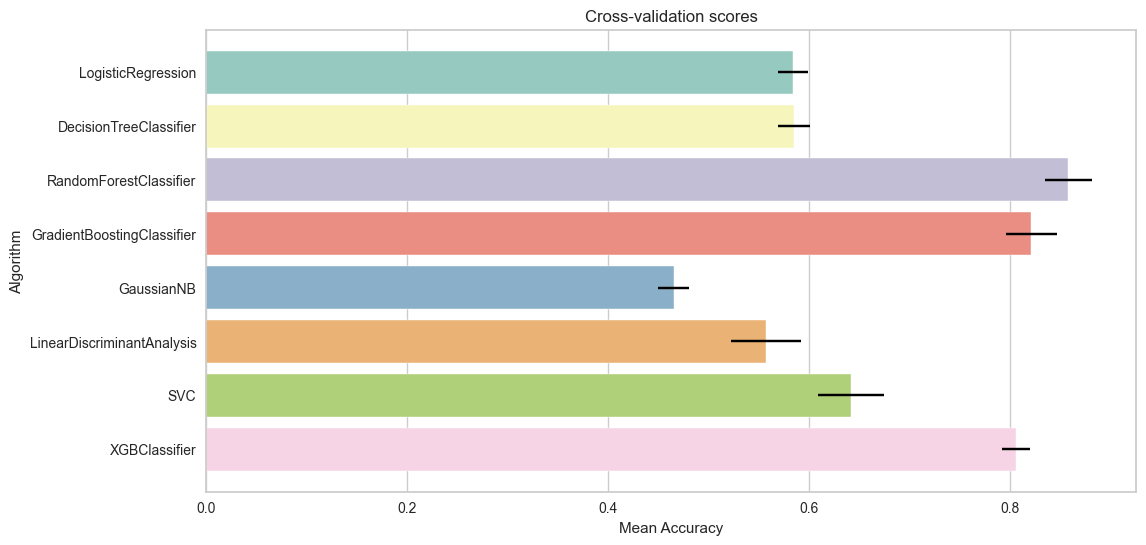

In [50]:
# Ensure consistency
cv_res = pd.DataFrame({"CrossValMeans": cv_acc, "CrossValerrors": cv_std, "Algorithm": clf_name})

# Plot
plt.figure(figsize=(12, 6))

# Barplot senza barre di errore
sns.barplot(
    x="CrossValMeans", y="Algorithm", data=cv_res,
    palette="Set3", orient="h"
)

# Aggiungi barre di errore manualmente
for index, row in cv_res.iterrows():
    plt.errorbar(
        x=row["CrossValMeans"], y=index, xerr=row["CrossValerrors"], fmt='none', c='black', capsize=5
    )

plt.xlabel("Mean Accuracy")
plt.title("Cross-validation scores")
plt.show()

In [51]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.583673,0.014997,LogisticRegression
1,0.584694,0.016004,DecisionTreeClassifier
2,0.858163,0.023358,RandomForestClassifier
3,0.821429,0.025612,GradientBoostingClassifier
4,0.465306,0.015609,GaussianNB
5,0.557143,0.034664,LinearDiscriminantAnalysis
6,0.641837,0.032812,SVC
7,0.806122,0.013690,XGBClassifier


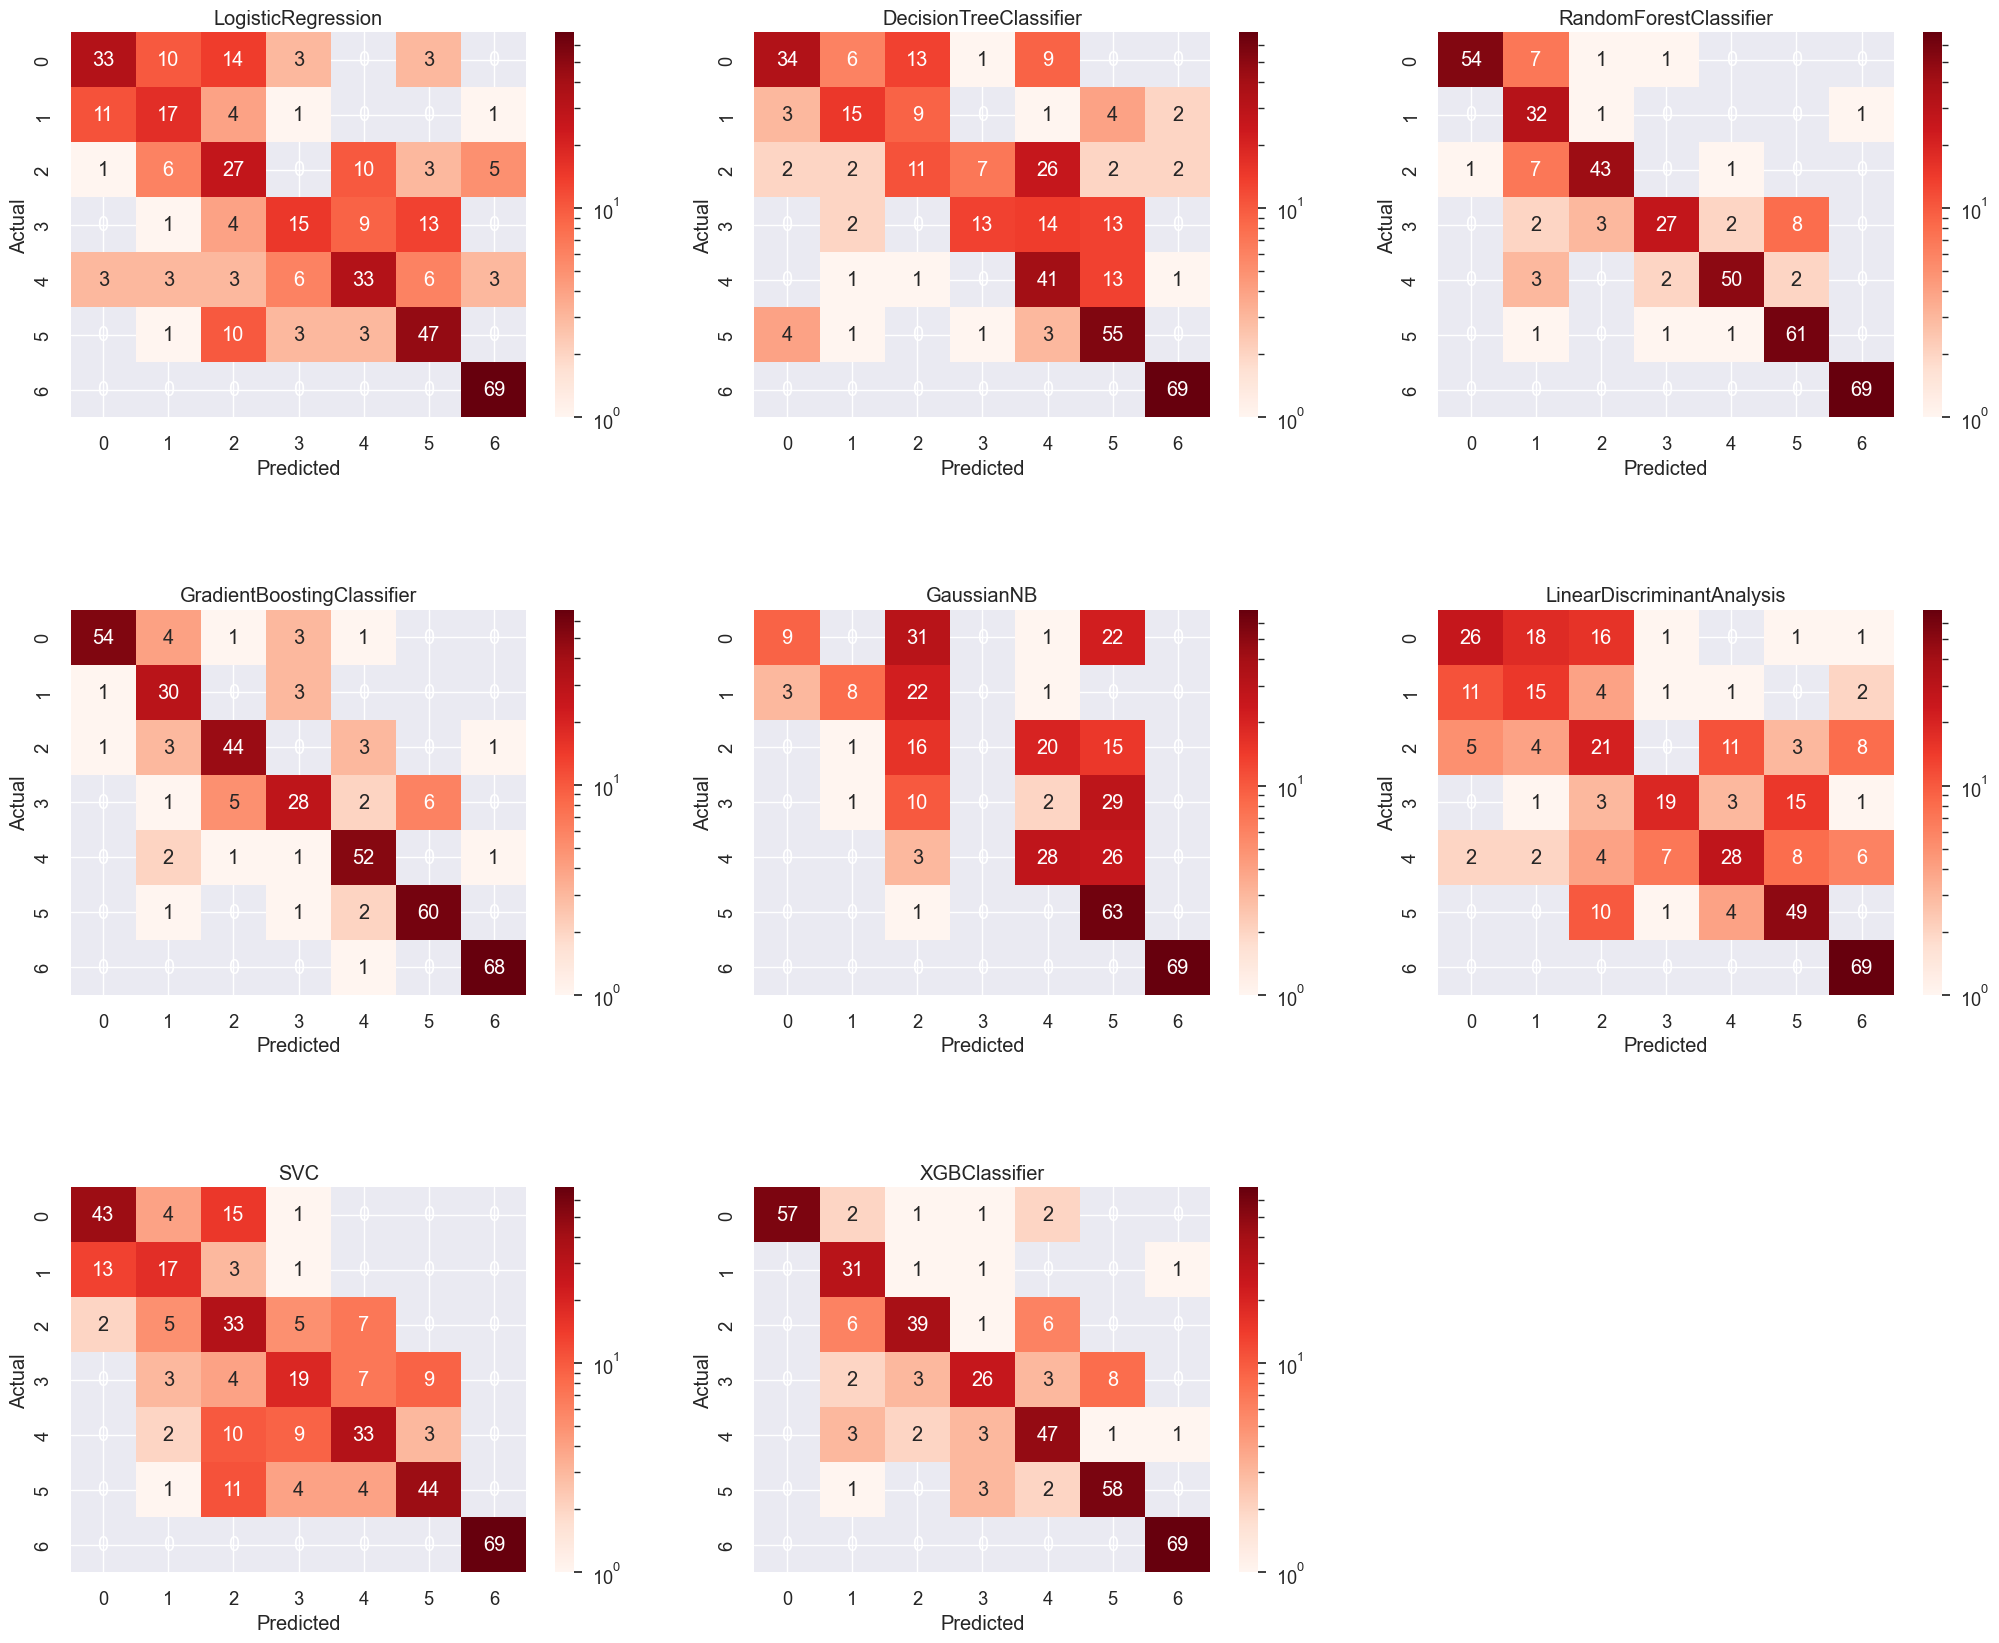

In [52]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,20))
sns.set(font_scale=1.2)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1)  # Adjust this according to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d", cmap="Reds", 
                norm=LogNorm(vmin=1, vmax=cnfm[i].max()))  # Emphasize lower values
    plt.subplots_adjust(hspace=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])


In [53]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        63
           1       0.45      0.50      0.47        34
           2       0.44      0.52      0.47        52
           3       0.54      0.36      0.43        42
           4       0.60      0.58      0.59        57
           5       0.65      0.73      0.69        64
           6       0.88      1.00      0.94        69

    accuracy                           0.63       381
   macro avg       0.61      0.60      0.60       381
weighted avg       0.63      0.63      0.63       381

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.54      0.64        63
           1       0.56      0.44      0.49        34
           2       0.32      0.21      0.26        52
           3       0.59      0.31      0.41        42
           4       0.44      0.72      0.54 

Text(0.5, 1.0, 'Correlation between models')

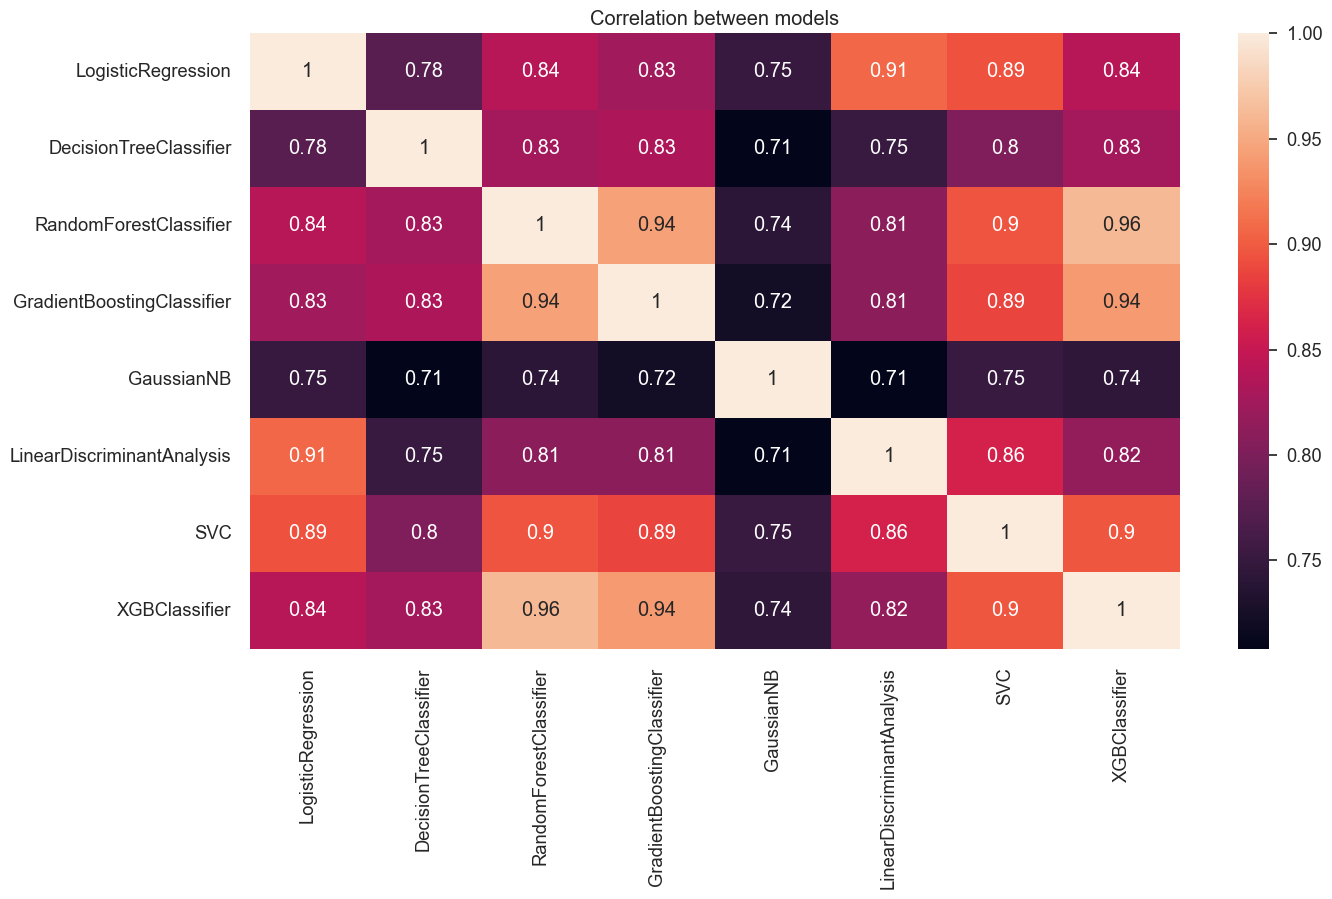

In [55]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop('weight_status', axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [56]:
# Search grid for optimal parameters

RF_param = {
    "max_depth": [None],
    "max_features": [0.3, 0.7, 1],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators" :[100,300],
    "criterion": ["gini"]
}

GB_param = {
    'loss' : ["log_loss"],
    'n_estimators' : [100,200,300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100,150],
    'max_features': [0.3, 0.1]
}


gs_model = []
score = []

In [57]:
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

RFgs.fit(x_train, y_train)
gs_model.append(RFgs.best_estimator_)
score.append(RFgs.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [58]:
GBgs = GridSearchCV(GradientBoostingClassifier(), param_grid=GB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1)

GBgs.fit(x_train, y_train)
gs_model.append(GBgs.best_estimator_)
score.append(GBgs.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [59]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[2], 3),  round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.858 0.821
score with GridSearchCV:  0.883 0.819


# Model Ensamble

In [60]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('rf', gs_model[0]), ('gb', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

0.8923884514435696


# Testing

In [62]:
# Load the test data
test = pd.read_csv("dataset/obesity_test.csv")

# Dizionario di mapping
mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

mapping_features =['CALC', 'CAEC']
# Applicare il mapping
test[mapping_features] = test[mapping_features].apply(lambda x: x.map(mapping))

# Dizionario di mapping
mapping = {
    'no': False,
    'yes': True
}

mapping_features =['SMOKE', 'family_history','FAVC', 'SCC']
# Applicare il mapping
test[mapping_features] = test[mapping_features].apply(lambda x: x.map(mapping))

# Variabili da standardizzare (con possibili outliers)
scaler = StandardScaler()

standard_features = ['Height', 'Age','FCVC','NCP', 'FAF','TUE', 'CH2O']
test[standard_features] = scaler.fit_transform(test[standard_features])


drop_features = [
    'Obesity', 'Weight'
]

test = test.drop(columns=drop_features, errors='ignore')

# Create dummies - for better model outcomes
test = df = pd.get_dummies(test, drop_first=True)


test['MTRANS_Bike'] = False

cols = test.columns.tolist()
mtrans_auto_index = cols.index('Gender_Male')
cols.insert(mtrans_auto_index + 1, cols.pop(cols.index('MTRANS_Bike')))
test = test[cols]

In [63]:
#train the model on the whole dataset and produce results:
pred = pd.Series(best_model.predict(test), name='weight_status')

In [64]:
pred.value_counts()

weight_status
0    46
2    45
5    32
6    30
3    26
4    26
1     5
Name: count, dtype: int64

# Yellowbrick

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


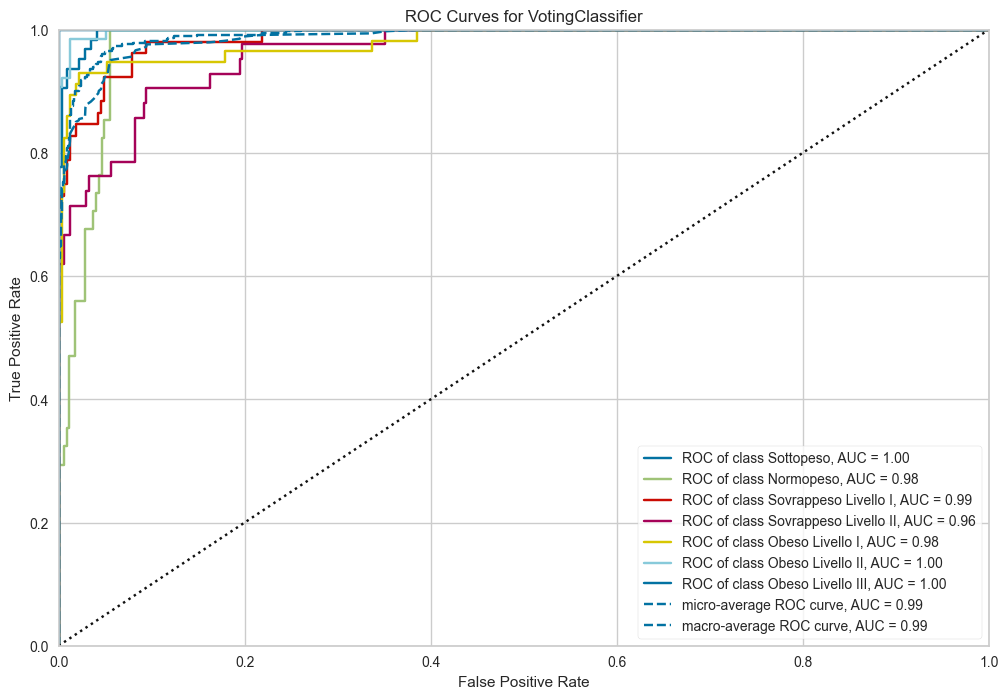

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# Assumendo che tu abbia un modello di classificazione già addestrato (ad esempio, RandomForest, SVM, etc.)
plt.figure(figsize=(12,8))

# Passa le classi (da 0 a 7) nel parametro 'classes'
visualizer = ROCAUC(best_model, classes=["Sottopeso", "Normopeso", "Sovrappeso Livello I", "Sovrappeso Livello II",
                                          "Obeso Livello I", "Obeso Livello II", "Obeso Livello III", "Non definito"], binary=False)

# Fit del modello sui dati di addestramento
visualizer.fit(x_train, y_train)

# Score del modello sui dati di test
visualizer.score(x_test, y_test)

# Mostra il grafico finale
visualizer.show()


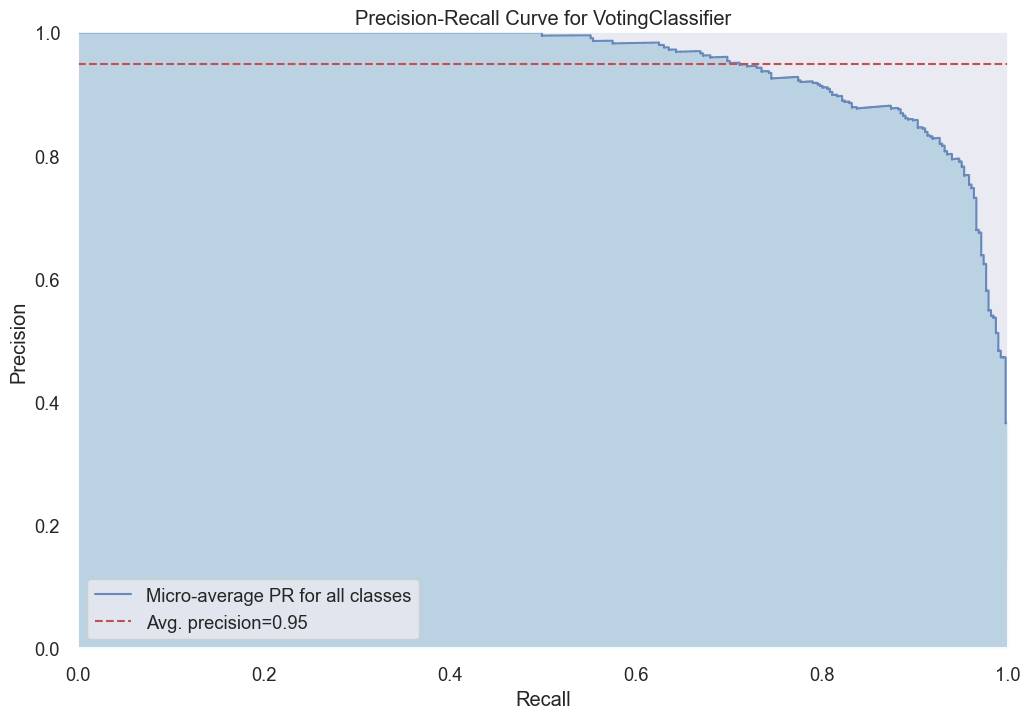

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [65]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

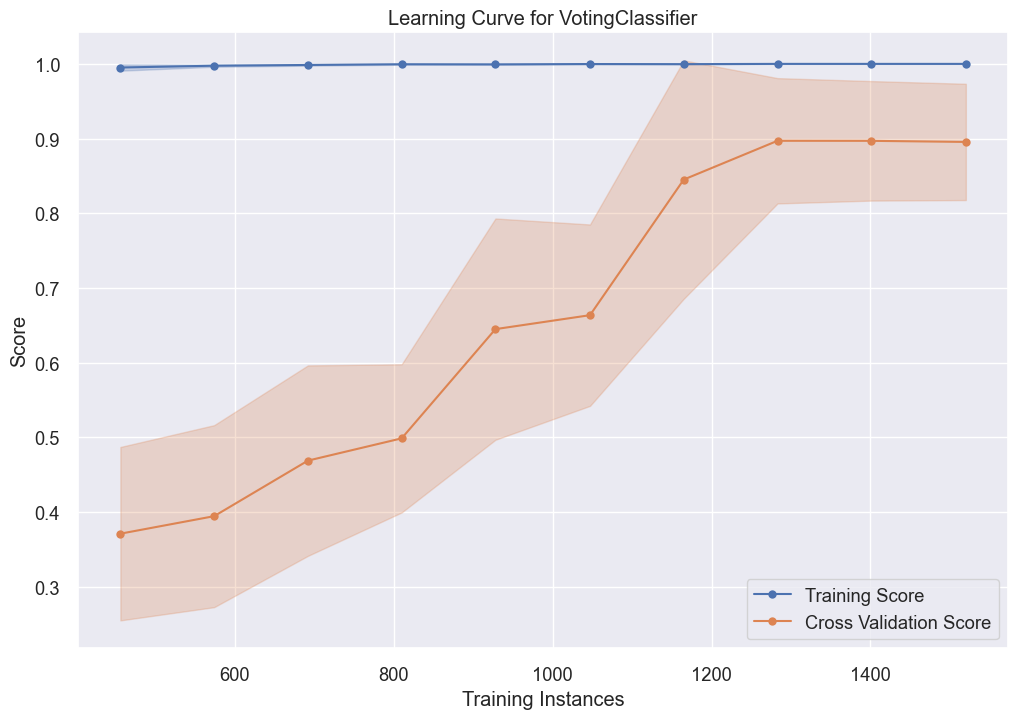

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [66]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure